In [1]:
from datasets import load_dataset
dataset = load_dataset("tianharjuno/twitter-parse", cache_dir="cache/")
sentiment_test = dataset["test_sentiment"]
relevancy_test = dataset["test"]

/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess the data by cleaning

In [2]:
import re, unicodedata, jaconv

_URL = re.compile(r"https?://\S+")
_MENTION = re.compile(r"@\w+")
_WS = re.compile(r"\s+")
_KUTI_CUT = re.compile(r"(?i)kutipan.*$", re.DOTALL)

def cleantext(row: str):
    text = row["content"]  # type: ignore
    text = unicodedata.normalize("NFKC", text)
    text = jaconv.z2h(text, kana=False, digit=True, ascii=True)
    text = text.replace("tanya grok", " ")
    text = text.replace("grokproductivitypasang", " ")
    text = text.replace("\\n", " ").replace("\\r", " ")

    # Handle standard URLs first
    text = _URL.sub(" <url> ", text)
    text = text.replace("ini tidak tersedia", " ")

    text = _MENTION.sub("@USER", text)
    text = re.sub(r"^rt\s+", "", text, flags=re.I)
    text = re.sub(r"(\b\d{4})(?=[a-zA-Z])", r"\1 ", text)
    text = _KUTI_CUT.sub("", text)
    
    text = _WS.sub(" ", text).strip()
    row["content"] = text  # type: ignore
    return row


In [3]:
sentiment_test = sentiment_test.map(cleantext, num_proc=10)
relevancy_test = relevancy_test.map(cleantext, num_proc=10)

In [4]:
sentiment_test = sentiment_test.rename_column("sentiment", "label")
relevancy_test = relevancy_test.rename_column("relevant", "label")

In [5]:
def calculate_weighted_metrics(eval_metrics):
    """
    Dynamically calculates weighted-average precision, recall, and F1
    for any number of classes based on HuggingFace eval metrics.

    Expects metric keys like:
        eval_ClassName_precision
        eval_ClassName_recall
        eval_ClassName_f1
        eval_ClassName_support
    """

    # Containers
    class_f1 = {}
    class_precision = {}
    class_recall = {}
    class_support = {}

    # Identify all class-specific entries
    for key, value in eval_metrics.items():
        if not key.startswith("eval_"):
            continue

        # Format: eval_<ClassName>_<metric>
        parts = key.split("_")
        if len(parts) < 3:
            continue

        class_name = parts[1]
        metric_name = parts[2]

        if metric_name == "f1":
            class_f1[class_name] = value
        elif metric_name == "precision":
            class_precision[class_name] = value
        elif metric_name == "recall":
            class_recall[class_name] = value
        elif metric_name == "support":
            class_support[class_name] = value

    # Validate support existence
    if not class_support:
        print("Error: No class support data found.")
        return {}

    # Total support
    total_support = sum(class_support.values())
    if total_support == 0:
        print("Error: Total support is zero.")
        return {}

    # Weighted metrics
    weighted_f1 = sum(class_f1[c] * class_support[c] for c in class_support) / total_support
    weighted_precision = sum(class_precision[c] * class_support[c] for c in class_support) / total_support
    weighted_recall = sum(class_recall[c] * class_support[c] for c in class_support) / total_support

    return {
        "weighted_f1": weighted_f1,
        "weighted_precision": weighted_precision,
        "weighted_recall": weighted_recall,
        "total_support": total_support,
        "classes": list(class_support.keys())
    }


In [6]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import numpy as np

def compute_metrics(class_names):
    num_classes = len(class_names)
    def callback(eval_pred):
        logits, labels = eval_pred
        if isinstance(logits, torch.Tensor):
            logits = logits.detach().cpu().numpy()
        if isinstance(labels, torch.Tensor):
            labels = labels.detach().cpu().numpy()
        preds = np.argmax(logits, axis=1)
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
            labels, preds, average="macro", zero_division=0
        )
        acc = accuracy_score(labels, preds)
        p_cls, r_cls, f1_cls, support_cls = precision_recall_fscore_support(
            labels,
            preds,
            average=None,
            zero_division=0,
            labels=list(range(num_classes)),
        )
        metrics = {
            "accuracy": acc,
            "macro_f1": macro_f1,
            "macro_precision": macro_p,
            "macro_recall": macro_r,
        }
        for idx, name in enumerate(class_names):
            metrics[f"{name}_precision"] = p_cls[idx]  # type: ignore
            metrics[f"{name}_recall"] = r_cls[idx]  # type: ignore
            metrics[f"{name}_f1"] = f1_cls[idx]  # type: ignore
            metrics[f"{name}_support"] = int(support_cls[idx])  # type: ignore
        return metrics
    return callback

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_cm(cm, class_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title(title)
    plt.show()


# Test the relevancy classifier only

ClassLabel(names=[False, True])


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


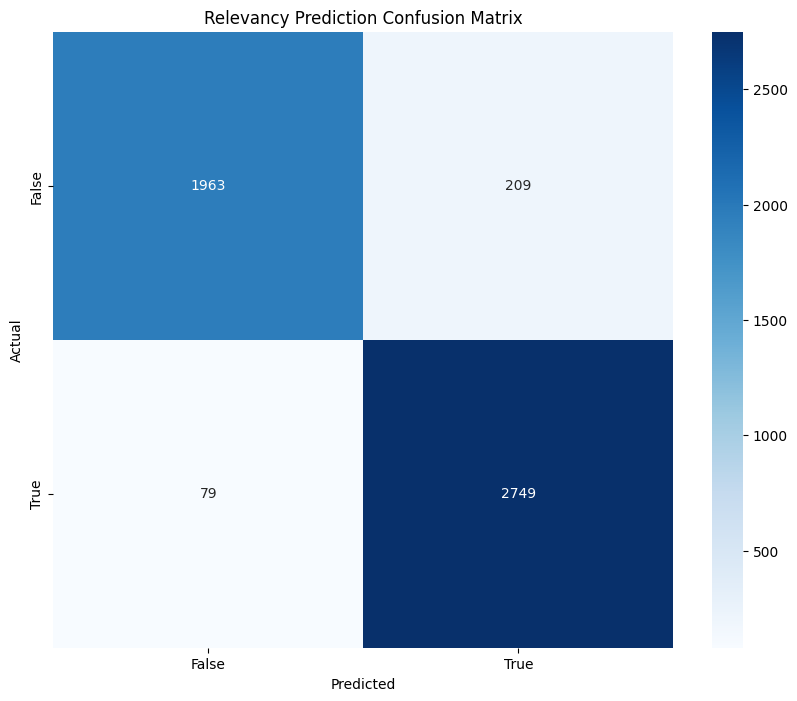

In [8]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, default_data_collator
from datasets import ClassLabel
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
class_labels = ClassLabel(names=list(set(relevancy_test["label"])))
print(class_labels)
relevancy_test = relevancy_test.cast_column("label", class_labels)
device = torch.device("mps")
model = AutoModelForSequenceClassification.from_pretrained(
    "tianharjuno/ruu-tni-relevancy-classification-p1", cache_dir="cache/", num_labels=len(class_labels.names)
)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("tianharjuno/ruu-tni-relevancy-classification-p1", cache_dir="cache/")

def tokenize(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", max_length=128)
tokenized_relevancy_test = relevancy_test.map(tokenize, num_proc=10, batched=True, batch_size=10)

training_args = TrainingArguments(
    overwrite_output_dir=True,
    eval_strategy="epoch",     # evaluate at the end of each epoch
    save_strategy="epoch",           # save checkpoint at the end of each epoch
    learning_rate=1e-5,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.05,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    warmup_ratio=0.01,
    bf16=True,
)
compute_metrics_callback = compute_metrics(class_labels.names)
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_relevancy_test,
    compute_metrics=compute_metrics_callback,
    data_collator=default_data_collator,
)

relevancy_results = trainer.evaluate()
relevancy_prediction_output = trainer.predict(tokenized_relevancy_test)
logits = relevancy_prediction_output.predictions
trus_labels = relevancy_prediction_output.label_ids

if isinstance(logits, tuple):
    logits = logits[0]
prediction_labels = logits.argmax(axis=-1)
relevancy_confusion_matrix = confusion_matrix(y_true=list(tokenized_relevancy_test["label"]), y_pred=prediction_labels)
plot_cm(relevancy_confusion_matrix, class_labels.names, "Relevancy Prediction Confusion Matrix")


In [9]:
weighted_relevancy_results = calculate_weighted_metrics(relevancy_results)
print(weighted_relevancy_results)
print(relevancy_results)

{'weighted_f1': 0.942158612141872, 'weighted_precision': 0.9432311754706272, 'weighted_recall': 0.9424, 'total_support': 5000, 'classes': ['False', 'True']}
{'eval_loss': 0.16675017774105072, 'eval_model_preparation_time': 0.0009, 'eval_accuracy': 0.9424, 'eval_macro_f1': 0.9409405318731645, 'eval_macro_precision': 0.9453282951195947, 'eval_macro_recall': 0.9379201929664158, 'eval_False_precision': 0.9613124387855044, 'eval_False_recall': 0.9037753222836096, 'eval_False_f1': 0.931656383483626, 'eval_False_support': 2172, 'eval_True_precision': 0.9293441514536849, 'eval_True_recall': 0.9720650636492221, 'eval_True_f1': 0.9502246802627031, 'eval_True_support': 2828, 'eval_runtime': 43.8574, 'eval_samples_per_second': 114.006, 'eval_steps_per_second': 1.801}


ClassLabel(names=[0, 1, 2])


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/christianharjuno/anaconda3/envs/sentiment/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


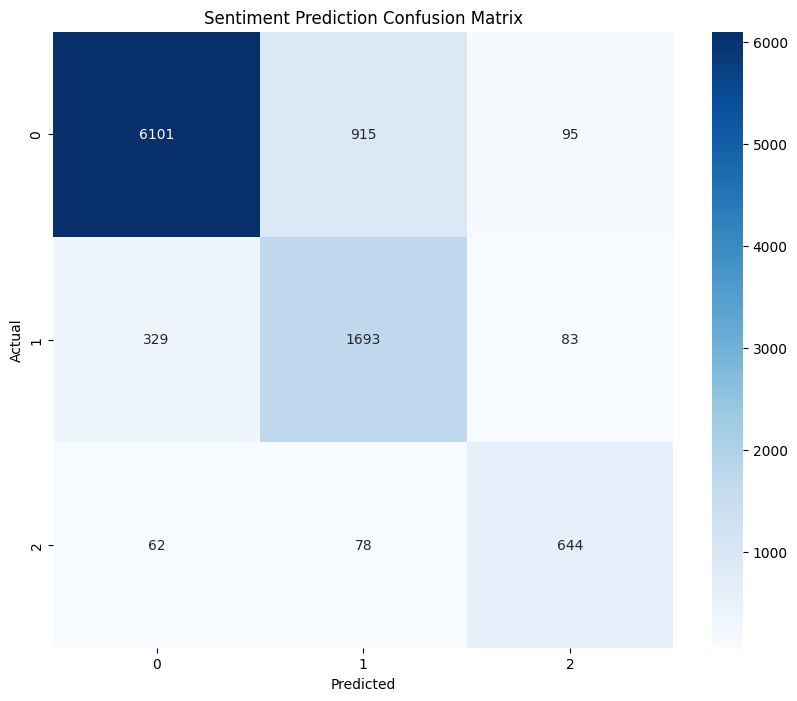

In [10]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, default_data_collator
from datasets import ClassLabel
import torch
class_labels = ClassLabel(names=list(set(sentiment_test["label"])))
print(class_labels)
relevancy_test = sentiment_test.cast_column("label", class_labels)
device = torch.device("mps")
model = AutoModelForSequenceClassification.from_pretrained(
    "tianharjuno/ruu-tni-sentiment-classification", cache_dir="cache/", num_labels=len(class_labels.names)
)
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("tianharjuno/ruu-tni-sentiment-classification", cache_dir="cache/")

def tokenize(batch):
    return tokenizer(batch["content"], truncation=True, padding="max_length", max_length=128)
tokenized_sentiment_test = sentiment_test.map(tokenize, num_proc=10, batched=True, batch_size=10)

training_args = TrainingArguments(
    overwrite_output_dir=True,
    eval_strategy="epoch",     # evaluate at the end of each epoch
    save_strategy="epoch",           # save checkpoint at the end of each epoch
    learning_rate=1e-5,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.05,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    warmup_ratio=0.01,
    bf16=True,
)
compute_metrics_callback = compute_metrics(class_labels.names)
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_sentiment_test,
    compute_metrics=compute_metrics_callback,
    data_collator=default_data_collator,
)

sentiment_results = trainer.evaluate()
sentiment_prediction_output = trainer.predict(tokenized_sentiment_test)
logits = sentiment_prediction_output.predictions
trus_labels = sentiment_prediction_output.label_ids

if isinstance(logits, tuple):
    logits = logits[0]
prediction_labels = logits.argmax(axis=-1)
sentiment_confusion_matrix = confusion_matrix(
    y_true=list(tokenized_sentiment_test["label"]), y_pred=prediction_labels
)
plot_cm(sentiment_confusion_matrix, class_labels.names, "Sentiment Prediction Confusion Matrix")


In [13]:
calculate_weighted_metrics(sentiment_results)
print(sentiment_results)

{'eval_loss': 0.3856523036956787, 'eval_model_preparation_time': 0.0009, 'eval_accuracy': 0.8438, 'eval_macro_f1': 0.8019141161713605, 'eval_macro_precision': 0.7845107672054902, 'eval_macro_recall': 0.8278902121991397, 'eval_0_precision': 0.9397720271102896, 'eval_0_recall': 0.8579665307270427, 'eval_0_f1': 0.8970080129383224, 'eval_0_support': 7111, 'eval_1_precision': 0.6303052866716307, 'eval_1_recall': 0.8042755344418052, 'eval_1_f1': 0.7067418075558338, 'eval_1_support': 2105, 'eval_2_precision': 0.7834549878345499, 'eval_2_recall': 0.8214285714285714, 'eval_2_f1': 0.8019925280199253, 'eval_2_support': 784, 'eval_runtime': 88.1958, 'eval_samples_per_second': 113.384, 'eval_steps_per_second': 1.78}
